<h1>Grid Search XGBoost</h1>

In [1]:
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import plot_importance
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

<h3>A - Prepare for Grid Search</h3>

In [2]:
features_names = [
    'flight_id',
    'month-day',
    'month',
    'day_in_month',
    'adep', 
    'country_code_adep', 
    'ades', 
    'country_code_ades', 
    'aircraft_type', 
    'wtc', 
    'airline', 
    'flight_duration', 
    'taxiout_time', 
    'flown_distance', 
    'actual_offblock_time_hour', 
    'actual_offblock_time_minute', 
    'actual_offblock_time_hour_minute', 
    'arrival_time_hour', 
    'arrival_time_minute', 
    'arrival_time_hour_minute', 
    'latitude_median', 
    'longitude_median', 
    'altitude_mean', 
    'groundspeed_mean', 
    'track_mean', 
    'vertical_rate_mean', 
    'track_unwrapped_mean', 
    'u_component_of_wind_mean', 
    'v_component_of_wind_mean', 
    'temperature_mean', 
    'specific_humidity_mean'
]

target = 'tow'

In [3]:
encoded_challenge_set = pd.read_csv('../../data/encoded_challenge_set.csv')

# Pick up features from dataset
features = encoded_challenge_set[features_names]

# Pick up target from dataset
target = encoded_challenge_set[target]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=123, shuffle=True)

In [4]:
# Function to score model using Root Mean Square Error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
    
# Create a scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Make cross validation strategy
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=123)

# Function to print the best parameters and best RMSE score after tunning
def print_model_score(grid_search):
    print("Best Parameters:", grid_search.best_params_)
    print("\nBest Score (Root Mean Squared Error):", grid_search.best_score_)

<h3>B - Perform Grid Search Random Forest Regressor</h3>

In [5]:
n_estimators = list(range(1,102,15))
max_depth = list(range(1, 11, 3))
learning_rate = [x / 10 for x in list(range(1, 10, 3))]
subsample = [x / 10 for x in list(range(1, 11, 3))]
colsample_bytree = [x / 10 for x in list(range(1, 11, 3))]

print(f"{n_estimators} = {len(n_estimators)} values")
print(f"{max_depth} = {len(max_depth)} values")
print(f"{learning_rate} = {len(learning_rate)} values")
print(f"{subsample} = {len(subsample)} values")
print(f"{colsample_bytree} = {len(colsample_bytree)} values")

run_time_in_seconds = (len(n_estimators)*len(max_depth)*len(learning_rate)*len(subsample)*len(colsample_bytree)) * 3 * 10
run_time_in_hours = (run_time_in_seconds/60)/60
print(f"{run_time_in_hours=}")

[1, 16, 31, 46, 61, 76, 91] = 7 values
[1, 4, 7, 10] = 4 values
[0.1, 0.4, 0.7] = 3 values
[0.1, 0.4, 0.7, 1.0] = 4 values
[0.1, 0.4, 0.7, 1.0] = 4 values
run_time_in_hours=11.2


In [6]:
param_grid = {
    'n_estimators': n_estimators,          # Number of trees
    'max_depth': max_depth,                # Maximum depth of a tree
    'learning_rate': learning_rate,     # Step size shrinkage used in updates
    'subsample': subsample,               # Subsample ratio of the training instance
    'colsample_bytree': colsample_bytree        # Subsample ratio of columns when constructing each tree
}

# Initialize the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=cv_strategy,
    n_jobs=-1,  # Use all available cores
    verbose=2
)  # Print detailed progress

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print Grid Search Results
print_model_score(grid_search)

Fitting 3 folds for each of 1344 candidates, totalling 4032 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 91, 'subsample': 1.0}

Best Score (Root Mean Squared Error): -3577.607425314009


<h3>C - Evaluate Best Estimator</h3>

In [7]:
best_xgb_reg = grid_search.best_estimator_
y_pred = best_xgb_reg.predict(X_test)
test_rmse = rmse(y_test, y_pred)
print("Test RMSE: ", test_rmse)

Test RMSE:  3526.7240161724703


<h3>D - Feature Importances</h3>

<Figure size 1000x800 with 0 Axes>

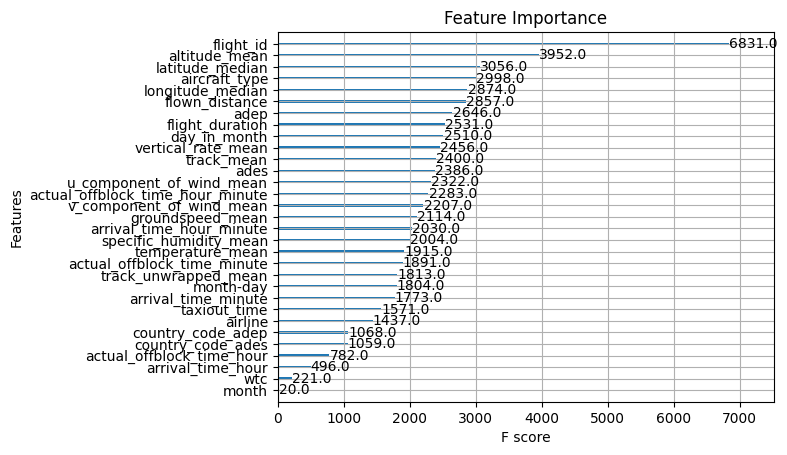

In [8]:
# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(best_xgb_reg, importance_type='weight')
plt.title('Feature Importance')
plt.show()